# Algorithmic Differentiation Example

In [16]:
import matplotlib.pyplot as plt
import numpy as np

In [17]:
import torch
from torch import nn
from torch.utils.data import DataLoader

# from torchvision import datasets
# from torchvision.transforms import ToTensor

from torch.utils.data import Dataset
from torch.utils.data import random_split
from torch.utils.tensorboard import SummaryWriter

In [18]:

class DenseModel(nn.Module):
    def __init__(self, num_inputs, num_hidden_layers, num_neurons_per_hidden_layer, dtype=torch.float64):
        super().__init__()

        layers = []
        in_features = num_inputs

        for _ in range(num_hidden_layers):
            layers.append(nn.Linear(in_features, num_neurons_per_hidden_layer, dtype=dtype))
            layers.append(nn.Softplus())
            in_features = num_neurons_per_hidden_layer

        layers.append(nn.Linear(in_features, 1, dtype=dtype))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


In [19]:
class DiffDeepLearning(nn.Module):
    def __init__(self, model):
        super(DiffDeepLearning, self).__init__()
        
        self.model = model

    def forward(self, x):

        y = self.model(x)
        grad = torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y))[0]

        return torch.concatenate([y, grad], dim=1)


tensor([[ 1.1338e+00, -1.9869e-03, -4.7510e-03,  2.1891e-03, -6.3797e-03,
         -3.1495e-03],
        [ 1.1366e+00, -2.3901e-03, -4.7354e-03,  1.9197e-03, -7.3985e-03,
         -3.1229e-03],
        [ 1.1313e+00, -2.2352e-03, -4.2394e-03,  2.1925e-03, -6.1926e-03,
         -2.4900e-03],
        [ 1.1327e+00, -3.2225e-03, -3.7085e-03,  1.3408e-03, -7.3562e-03,
         -1.6576e-03],
        [ 1.1378e+00, -2.0477e-03, -4.7893e-03,  1.8646e-03, -7.9197e-03,
         -3.2964e-03],
        [ 1.1366e+00, -2.6251e-03, -5.3258e-03,  1.3647e-03, -7.3925e-03,
         -3.0858e-03],
        [ 1.1385e+00, -3.4354e-03, -5.2476e-03, -3.8625e-04, -8.1494e-03,
         -2.5269e-03],
        [ 1.1342e+00, -4.1307e-03, -4.7120e-03, -3.3709e-04, -7.0820e-03,
         -1.5604e-03],
        [ 1.1359e+00, -3.1138e-03, -4.7544e-03,  1.1285e-03, -7.1248e-03,
         -2.7035e-03],
        [ 1.1316e+00, -2.4676e-03, -3.4694e-03,  1.4785e-03, -5.4101e-03,
         -2.4723e-03]], dtype=torch.float64, grad_fn=

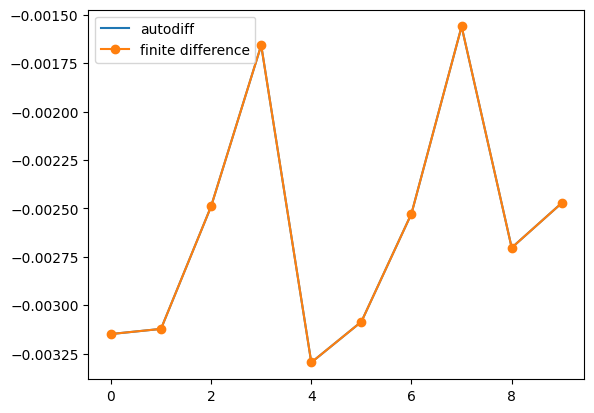

In [20]:
model = DenseModel(num_inputs=5, num_hidden_layers=3, num_neurons_per_hidden_layer=64)

algdiffmodel = DiffDeepLearning(model)


x = torch.rand(10, 5, dtype=torch.float64, requires_grad=True)

y = algdiffmodel(x)

print(y)

col = 4
ep = 1e-6

x__ = x.clone()

x__[:, col] += torch.tensor(ep)

y2 = algdiffmodel(x__)

test = (y2[:, 0] - y[:, 0]) / ep

print(test)

plt.plot(y[:,col+1].detach().numpy(), label='autodiff')

plt.plot(test.detach().numpy(), label='finite difference', marker='o')

plt.legend()


In [11]:

print(algdiffmodel)


DiffDeepLearning(
  (model): DenseModel(
    (net): Sequential(
      (0): Linear(in_features=5, out_features=64, bias=True)
      (1): Softplus(beta=1.0, threshold=20.0)
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Softplus(beta=1.0, threshold=20.0)
      (4): Linear(in_features=64, out_features=64, bias=True)
      (5): Softplus(beta=1.0, threshold=20.0)
      (6): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)


In [26]:
torch.save(algdiffmodel, "../MODELS/algdiffmodel.pth")

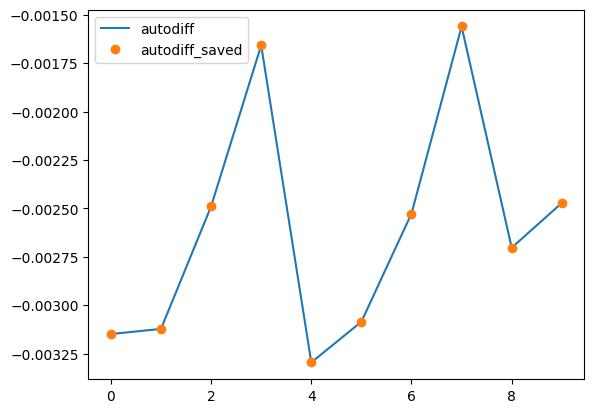

In [35]:
saved_dense = torch.load("../MODELS/algdiffmodel.pth", weights_only=False)

y_saved = saved_dense(x) 

plt.plot(y[:,col+1].detach().numpy(), label='autodiff')
plt.plot(y_saved[:,col+1].detach().numpy(), 'o',label='autodiff_saved')
plt.legend()




In [39]:
loss = nn.MSELoss()

type(loss)

torch.nn.modules.loss.MSELoss

In [ ]:
class DiffLearningLoss(nn.Module):
    
    def __init__(self, alpha, dydX_scaled_L2_norm):

        self.alpha = alpha
        self.dydX_scaled_L2_norm = dydX_scaled_L2_norm

    def forward(self, pred, target):

        return (

In [ ]:
class DiffLearningFullModel:

    def __init__(self, model, loss_fn, optimizer, train_dataloader, val_dataloader = None):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader

    def retrieve_normalization_params(self):

        self.X_mu = self.train_dataloader.data.X_mu
        self.X_sigma = self.train_dataloader.data.X_sigma

        self.y_mu = self.train_dataloader.data.y_mu
        self.y_sigma = self.train_dataloader.data.y_sigma 

        self.dydX_scaled_L2_norm = self.train_dataloader.dydX_scaled_L2_norm


    def train(self, epochs, writer=None):

        
        for epoch in range(epochs):
            self.model.train()
            train_loss = 0.0
            for batch, (X, y) in enumerate(self.train_dataloader):
                X = X.requires_grad_(True)
                pred = self.model(X)
                loss = self.loss_fn(pred, y)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()
            train_loss /= len(self.train_dataloader)

            self.model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for X, y in self.val_dataloader:
                    X = X.requires_grad_(True)
                    pred = self.model(X)
                    loss = self.loss_fn(pred, y)
                    val_loss += loss.item()
            val_loss /= len(self.val_dataloader)

            if writer:
                writer.add_scalar('Loss/train', train_loss, epoch)
                writer.add_scalar('Loss/val', val_loss, epoch)

            print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

IndentationError: expected an indented block after function definition on line 10 (514682896.py, line 12)

In [13]:
X = torch.rand(100, 5, dtype=torch.float64)

In [14]:
X.mean(dim=0)


tensor([0.5199, 0.5066, 0.5100, 0.4685, 0.4624], dtype=torch.float64)

# Custon dataset

In [36]:
class DiffDeepLearningDataset(Dataset):
    def __init__(self, x_file, y_file):
        # Class constructor:
        # Loads the dataset from files:

        X = np.load(x_file)
        y = np.load(y_file)

        self.X_mu = np.mean(X, axis = 0)
        self.X_sigma = np.std(X, axis = 0) + 1e-8

        self.y_mu = np.mean(y[:,0])
        self.y_sigma = np.std(y[:,0]) + 1e-8

        y[:,1:] *= self.X_sigma / self.y_sigma  

        self.dydX_scaled_L2_norm = np.mean(y[:,1:]*y[:,1:], axis = 0) + 1e-8

        self.X = torch.tensor(X, dtype=torch.float64) 
        self.y_dxdy = torch.tensor(y, dtype=torch.float64)

        
        self.len = self.X.shape[0]

    def __getitem__(self, index):
        # Retrieves an item from the dataset:
        # In very big daytasets, we should not load all data at once.

        return self.X[index], self.y[index]
        # TODO: convert to tensor 
        
    def __len__(self):
        # Returns the length of the dataset:
        return self.len